# Frequency Filtering, Convolution Efficiency, and Deconvolution
Digital Signal and Image Processing – notebook 3

Luca Calatroni
luca.calatroni@unige.it

In this notebook we will:

1. Consider Ideal, Butterworth and Gaussian low-pass filters in the frequency domain based on the definition of critical distances

2. Compare the shape of the filters, their performance for different critical distances and their artefacts

3. Use the routine before to compute Ideal, Butterworth and Gaussian high-pass filters in the frequency domain and test them

4. Compare 2D convolution in the spatial domain and using the FFT for a given filter of increasing size and compare their computational costs

5. Introduce the image deconvolution problem for two (small/large) Gaussian blur kernels and one motion kernel, with no noise.

$+$ Project assignments: introduce noise in the observed blurred images and perform deconvolution, elaborating strategies to fix this.

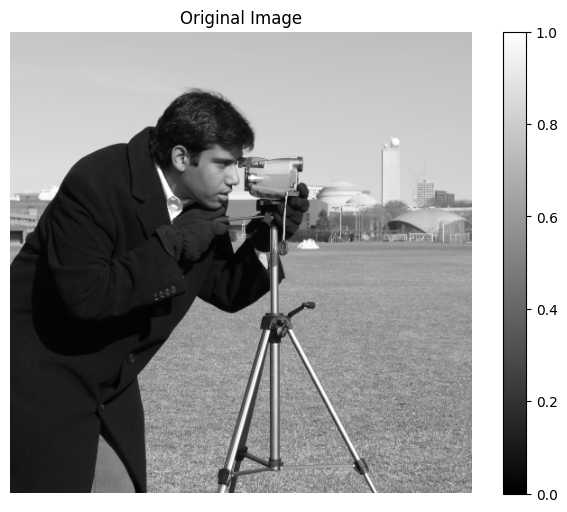

In [66]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, ndimage, signal
from skimage import data, img_as_float
from time import perf_counter

# Set default figure size for plots and load sample image

plt.rcParams['figure.figsize'] = (8,6)

img = img_as_float(data.camera())
rows, cols = img.shape

def show(img, title="", cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.colorbar()  
    plt.axis('off')
    plt.show()

show(img, "Original Image")


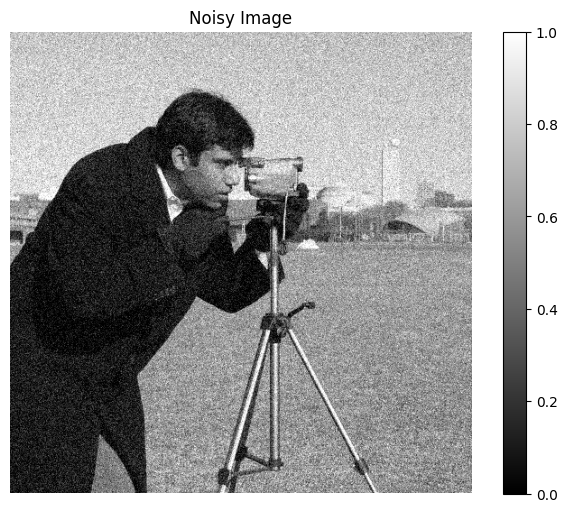

In [67]:
# Add noise to the image
np.random.seed(0)
noise_sigma = 0.1
noisy_img = img + noise_sigma * np.random.normal(size=img.shape)
noisy_img = np.clip(noisy_img, 0, 1)
show(noisy_img, "Noisy Image")

In [68]:
# Define SNR and PSNR functions

def SNR(original, noisy):
    num = np.linalg.norm(original)
    den = np.linalg.norm(original - noisy)
    return 20 * np.log10(num / den)

def PSNR(original, reconstructed):
    mse = np.mean((original - reconstructed)**2)
    maxv = 1.0  # assume normalized image
    return 20 * np.log10(maxv / np.sqrt(mse))

# Print SNR and PSNR of the noisy image
print(f"SNR of noisy image: {SNR(img, noisy_img):.2f} dB")
print(f"PSNR of noisy image: {PSNR(img, noisy_img,):.2f} dB")


SNR of noisy image: 15.76 dB
PSNR of noisy image: 20.45 dB


## 2. Frequency-based filtering 
We now construct ideal, Butterworth and Gaussian filters performing frequency-based filtering.
For this we first construct a simple distance map from the origin in the frequency plane.

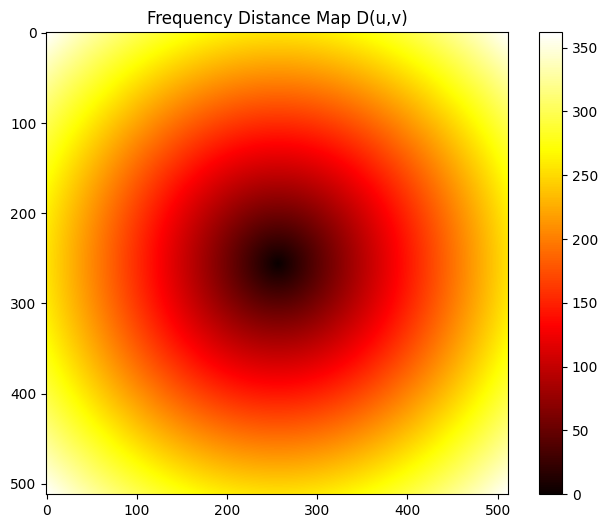

In [69]:
# Create frequency distance map D(u,v) from the center of the frequency rectangle with size equal to the image size

u = np.arange(rows)
v = np.arange(cols)
U, V = np.meshgrid(u - rows//2, v - cols//2, indexing='ij')
# Complete
D = np.sqrt(U**2 + V**2)

plt.imshow(D, cmap='hot')
plt.title("Frequency Distance Map D(u,v)")
plt.colorbar()
plt.show()

In [70]:
# Define frequency domain filters: ideal, Butterworth, Gaussian
# Output: transfrer function H(u,v) depending on cutoff distance D0 given as input

def ideal_filter(D,D0):
    mask = np.zeros(D.shape)
    # Ideal LPF: sharp circular cutoff
    # Complete
    mask = (D <= D0).astype(float)
    return mask

def butterworth_filter(D,D0,n=2):
    mask = np.zeros(D.shape)
    # Butterworth LPF: smooth transition
    # Complete
    mask = 1 / (1 + (D/D0)**(2*n))
    return mask

def gaussian_filter(D,D0):
    mask = np.zeros(D.shape)
    # Gaussian LPF: smoothest falloff
    # Complete
    mask = np.exp(-(D**2)/(2*D0**2))
    return mask

# Apply frequency filter to image using transfer function H(u,v) and return filtered image. Use FFT and inverse FFT.

def apply_freq_filter(img, H):
    # Apply filter: FFT → shift → multiply → inverse FFT
    F = fftpack.fftshift(fftpack.fft2(img))
    # Complete
    G = F * H
    # Complete taking real part of inverse FFT (it should be real)
    filtered = np.real(fftpack.ifft2(fftpack.ifftshift(G)))
    return filtered


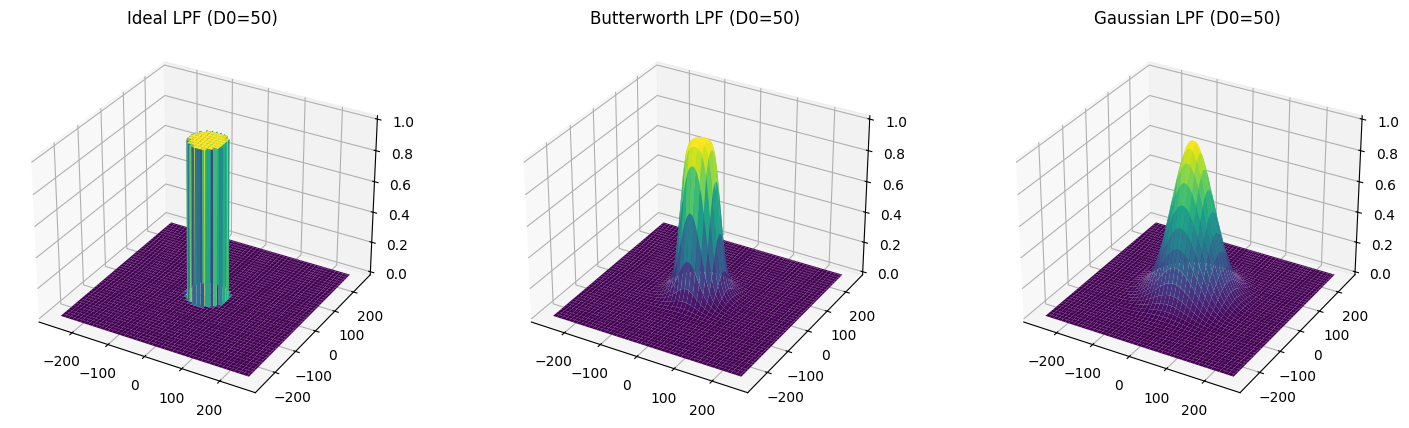

In [71]:
# Show surface representation of filters
D0 = 50
H_ideal = ideal_filter(D,D0)
H_butter = butterworth_filter(D,D0, n=3)
H_gauss = gaussian_filter(D,D0)   

fig = plt.figure(figsize=(18,5))    
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U, V, H_ideal, cmap='viridis')
ax1.set_title("Ideal LPF (D0={})".format(D0))
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(U, V, H_butter, cmap='viridis')
ax2.set_title("Butterworth LPF (D0={})".format(D0)) # plot Butterwoarth with input n 
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(U, V, H_gauss, cmap='viridis')
ax3.set_title("Gaussian LPF (D0={})".format(D0))
plt.show()  

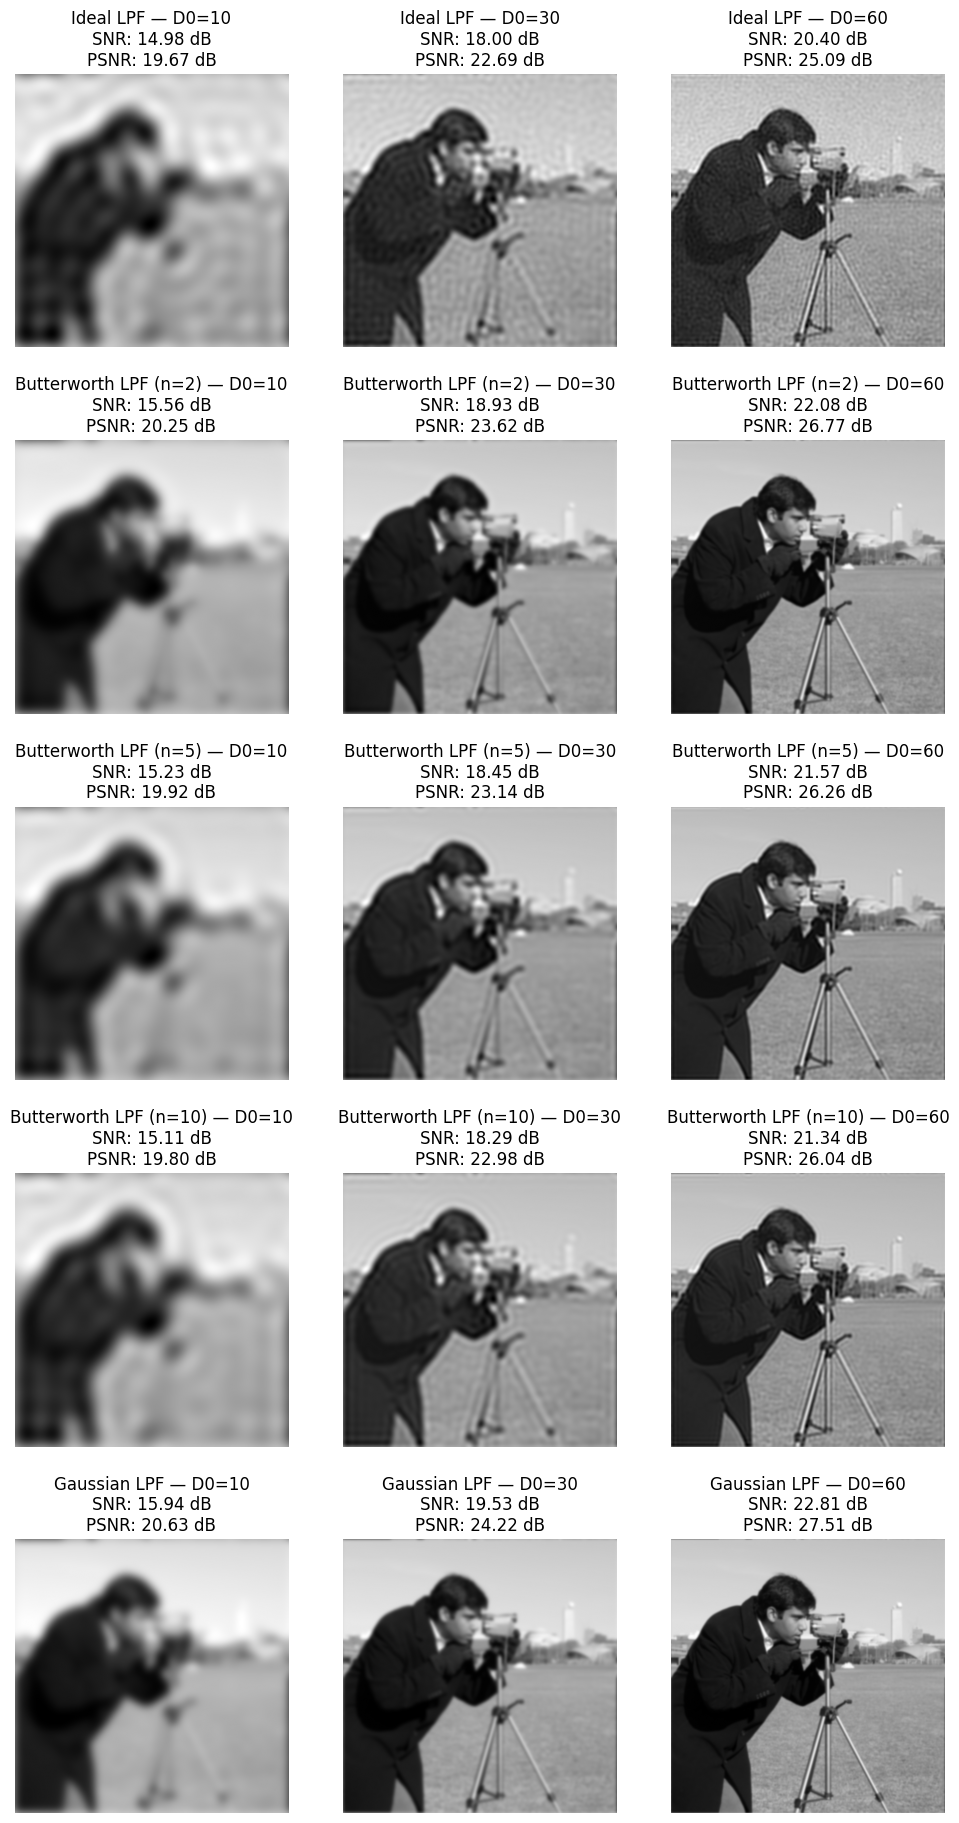

In [72]:
# Apply filters with different cutoff distancies and show results.
# Compute SNR and PSNR for all results

cutoffs=[10,30,60]

# For Butterworth filter, use several orders
orders = [2, 5, 10]

fig,axes=plt.subplots(5,3,figsize=(12,23))
filter_idx = 0

# Ideal filter
for j,c in enumerate(cutoffs):
    H=ideal_filter(D,c)
    out=apply_freq_filter(noisy_img,H)
    axes[filter_idx,j].imshow(out,cmap='gray')
    axes[filter_idx,j].set_title(f"Ideal LPF — D0={c}\nSNR: {SNR(img, out):.2f} dB\nPSNR: {PSNR(img, out):.2f} dB")
    axes[filter_idx,j].axis('off')

# Butterworth filters with different orders
for n_order in orders:
    filter_idx += 1
    for j,c in enumerate(cutoffs):
        H = butterworth_filter(D,c, n=n_order)
        out=apply_freq_filter(img,H)
        axes[filter_idx,j].imshow(out,cmap='gray')
        axes[filter_idx,j].set_title(f"Butterworth LPF (n={n_order}) — D0={c}\nSNR: {SNR(img, out):.2f} dB\nPSNR: {PSNR(img, out):.2f} dB")
        axes[filter_idx,j].axis('off')

# Gaussian filter
filter_idx += 1
for j,c in enumerate(cutoffs):
    H=gaussian_filter(D,c)
    out=apply_freq_filter(img,H)
    axes[filter_idx,j].imshow(out,cmap='gray')
    axes[filter_idx,j].set_title(f"Gaussian LPF — D0={c}\nSNR: {SNR(img, out):.2f} dB\nPSNR: {PSNR(img, out):.2f} dB")
    axes[filter_idx,j].axis('off')
plt.show()


What do you observe? What is the best filtering for each cutoff distance? Do you observe artefacts?

## 3. Implement High-Pass Filters and Compare Them
Using the simple formulas we have seen in lecutres, implement now the ideal, Butterworth and Gaussian high-pass filters.

In [73]:
# Define high-pass filters corresponding to the low-pass filters defined above using the functions already defined

def ideal_high_pass(D,D0):
    # Complete
    mask = 1 - ideal_filter(D, D0)
    return mask

def butterworth_high_pass(D,D0, n=2):
    # HPF = 1 - Butterworth LPF
    # Complete
    mask = 1 - butterworth_filter(D, D0, n)
    return mask

def gaussian_high_pass(D,D0):
    # HPF = 1 - Gaussian LPF
    # Complete
    mask = 1 - gaussian_filter(D, D0)
    return mask


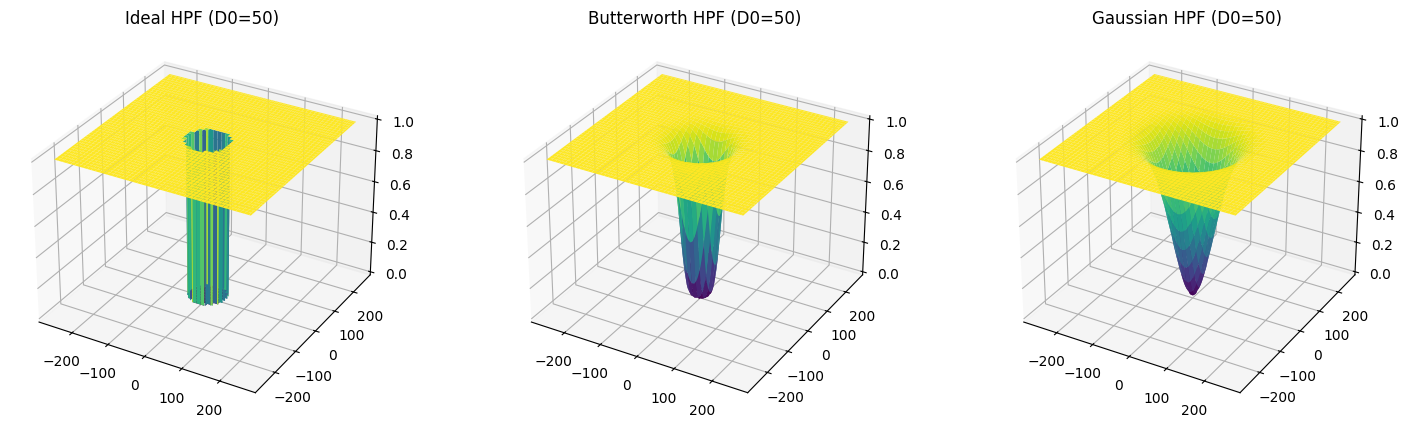

In [74]:
# Plot high-pass filters

D0 = 50
H_ideal_hp = ideal_high_pass(D,D0)
H_butter_hp = butterworth_high_pass(D,D0, n=3)               
H_gauss_hp = gaussian_high_pass(D,D0) 

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U, V, H_ideal_hp, cmap='viridis')
ax1.set_title("Ideal HPF (D0={})".format(D0))
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(U, V, H_butter_hp, cmap='viridis')
ax2.set_title("Butterworth HPF (D0={})".format(D0))
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(U, V, H_gauss_hp, cmap='viridis')
ax3.set_title("Gaussian HPF (D0={})".format(D0))
plt.show()


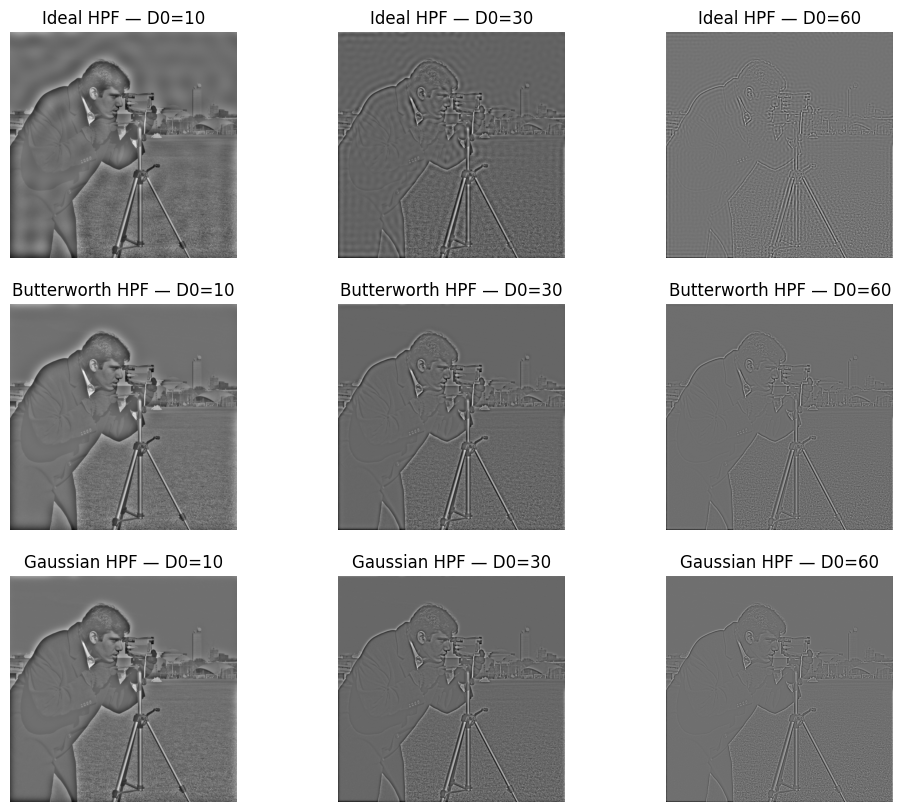

In [75]:
# Apply high-pass filters with different cutoff distances and show results

cutoffs=[10,30,60]
filters=[ideal_high_pass,butterworth_high_pass,gaussian_high_pass]
names=['Ideal','Butterworth','Gaussian']

fig,axes=plt.subplots(3,3,figsize=(12,10))
for i,f in enumerate(filters):
    for j,c in enumerate(cutoffs):
        H=f(D,c)
        out=apply_freq_filter(img,H)
        axes[i,j].imshow(out,cmap='gray')
        axes[i,j].set_title(f"{names[i]} HPF — D0={c}")
        axes[i,j].axis('off')
plt.show()

## 4. Spatial vs FFT Convolution Timing
We now verify the computational advantages of using FFT in comparison to direct spatial 2D convolution with reflective padding.
Consider a simple averaging kernel of odd size and compute the CPU time to perform spatial 2D convolution against the time required to perform frequency filtering (pointwise multiplication) and inversion. 

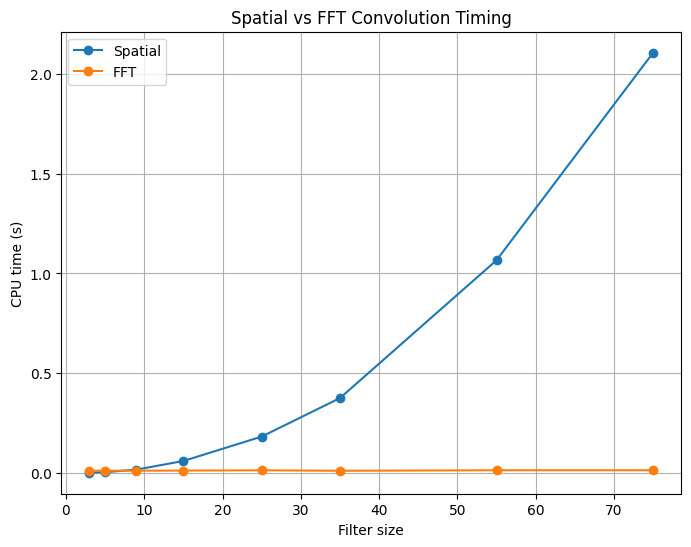

In [76]:
# Compare timing of spatial vs frequency convolution for different filter sizes

sizes=[3,5,9,15,25,35,55,75]
t_spatial=[]
t_fft=[]

# For each filter size, create a normalized averaging filter and time spatial and frequency convolution

for k in sizes:
    # Complete using formula for averaging filter
    kernel= np.ones((k, k)) / (k * k)

    t0=perf_counter()
    # perform spatial convolution with reflective padding (see later)
    ndimage.convolve(img,kernel,mode='reflect')
    t_spatial.append(perf_counter()-t0)

    # perform frequency convolution using FFT
    t0=perf_counter()
    # Complete
    F = fftpack.fft2(img)
    K = fftpack.fft2(np.pad(kernel, ((0, img.shape[0]-k), (0, img.shape[1]-k))))
    out = np.real(fftpack.ifft2(F * K))
    t_fft.append(perf_counter()-t0)

# Plot timing results

plt.plot(sizes,t_spatial,'o-',label='Spatial')
plt.plot(sizes,t_fft,'o-',label='FFT')
plt.xlabel("Filter size")
plt.ylabel("CPU time (s)")
plt.legend()
plt.grid(True)
plt.title("Spatial vs FFT Convolution Timing")
plt.show()

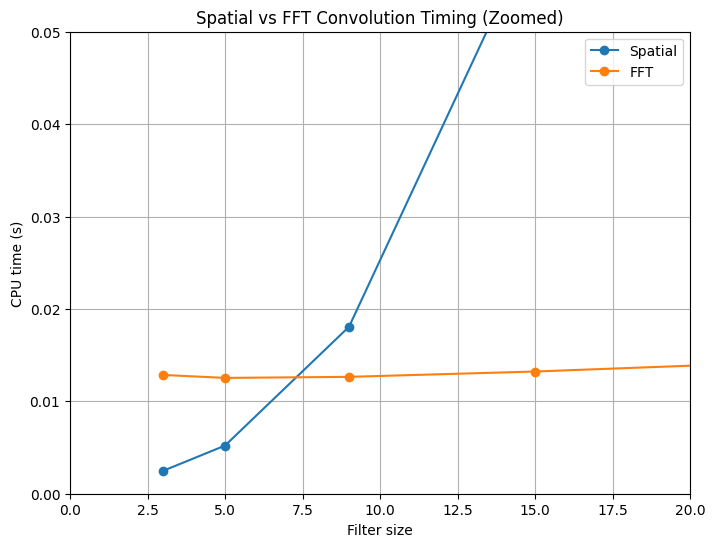

In [77]:
# Plot a zoom for small filter sizes

plt.plot(sizes,t_spatial,'o-',label='Spatial')
plt.plot(sizes,t_fft,'o-',label='FFT')
plt.xlabel("Filter size")
plt.ylabel("CPU time (s)")
plt.xlim(0,20)
plt.ylim(0,0.05)           
plt.legend()
plt.grid(True)
plt.title("Spatial vs FFT Convolution Timing (Zoomed)")
plt.show()  

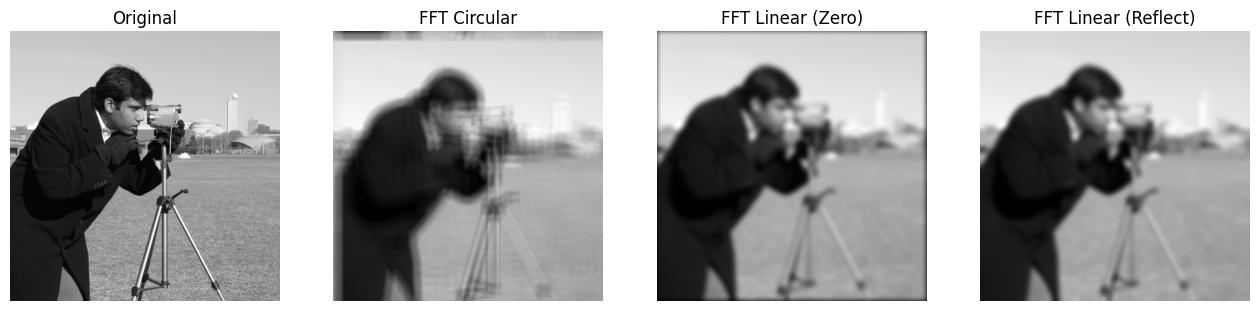

In [78]:
# We now compare circular versus linear convolution on a Gaussian blur example

# Define a simple Gaussian kernel

def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size//2), size//2, size)
    xx, yy = np.meshgrid(ax, ax)
    k = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    return k/np.sum(k)

k_size = 21 
sigma = 5.0
k = gaussian_kernel(k_size, sigma)

# Complete, fix the padding size (making sure it's an integer number)
pad= k_size // 2

# Common FFT-based linear convolution with padding (zero or reflect)

def fft_linear_convolve(img, kernel, pad, mode):
    # pad image
    if mode == 'constant': # Complete, impose zero padding
        img_pad = np.pad(img, pad_width=pad, mode='constant', constant_values=0)
    elif mode == 'reflect':
        img_pad = np.pad(img, pad_width=pad, mode='reflect')
    # center-place kernel into padded shape, then ifftshift before FFT
    kr, kc = kernel.shape
    ar_shape = img_pad.shape
    ker_centered = np.zeros(ar_shape, dtype=kernel.dtype)
    # Here we center the kernel in the padded array. To do so, compute the starting row and column
    # This is needed to align the kernel correctly with the padded image for using convolution theorem
    # Complete
    r0 = (ar_shape[0] - kr) // 2
    c0 = (ar_shape[1] - kc) // 2
    # Here you place the kernel into the centered position
    # Complete
    ker_centered[r0:r0+kr, c0:c0+kc] = kernel 
    ker_shifted = fftpack.ifftshift(ker_centered)
    # FFT multiply and inverse
    F_img = fftpack.fft2(img_pad)
    F_k = fftpack.fft2(ker_shifted)
    out_full = np.real(fftpack.ifft2(F_img * F_k))
    # center crop back to original size
    # Complete
    return out_full[pad:-pad, pad:-pad]

# FFT circular convolution (wrap-around expected)
F_img = fftpack.fft2(img)
F_k = fftpack.fft2(fftpack.ifftshift(k), img.shape)  # center PSF
circ = np.real(fftpack.ifft2(F_img * F_k))

# SAME FFT routine for zero and reflect padding
lin_zero_fft = fft_linear_convolve(img, k, pad=pad, mode='constant')
lin_reflect_fft = fft_linear_convolve(img, k, pad=pad, mode='reflect')

# Show results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img, cmap='gray'); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(circ, cmap='gray'); axes[1].set_title('FFT Circular'); axes[1].axis('off')
axes[2].imshow(lin_zero_fft, cmap='gray'); axes[2].set_title('FFT Linear (Zero)'); axes[2].axis('off')
axes[3].imshow(lin_reflect_fft, cmap='gray'); axes[3].set_title('FFT Linear (Reflect)'); axes[3].axis('off')
plt.show()

## 5. Introduction to image deconvolution problem
Apply blurs of different type and intensity to see the effect on the reference image.
For simplicity, use only two levels of Gaussian blurs, one small, one high.

This blurring process simulates, for instance, the effect of a out-of-focus acquisition.

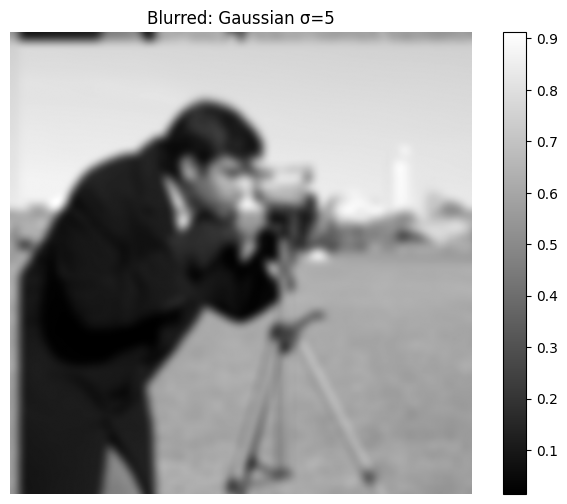

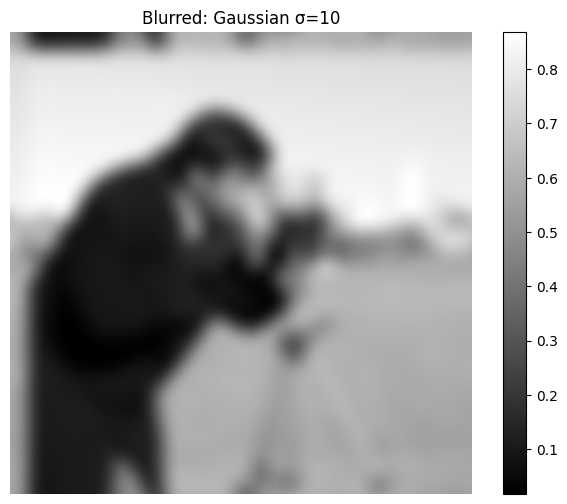

In [79]:
# Create and show different blur kernels: Gaussian with different sigmas and motion blur

kernels = {
    "Gaussian σ=5": gaussian_kernel(21,5),
    "Gaussian σ=10": gaussian_kernel(41,10),
}

# Blur images: convolve with kernels using FFT (assume boundary conditions lead to circular convolution)

blurred_images={}
for name,k in kernels.items():
    # Complete
    K = fftpack.fft2(k, img.shape)
    F = fftpack.fft2(img)
    blurred_images[name] = np.real(fftpack.ifft2(F * K))

# Show blurred images   
for name,bimg in blurred_images.items():
    show(bimg, f"Blurred: {name}")

# Note artefacts due to the periodic assumption of FFT-based convolution
# Comapre with zero-padding based convolution 

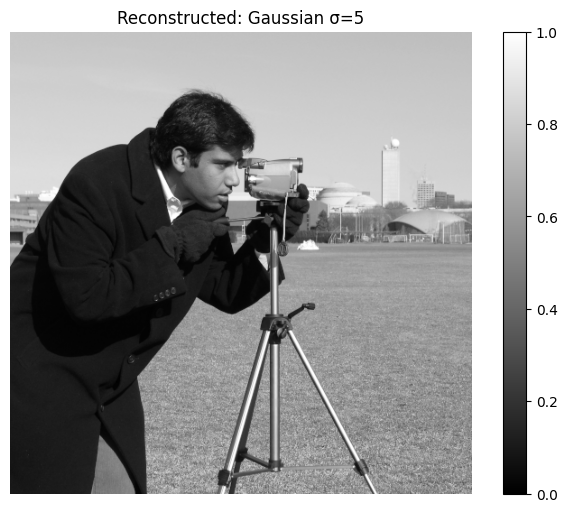

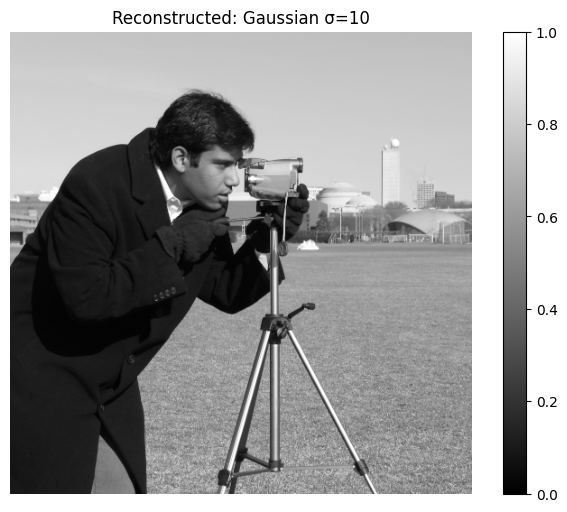

In [80]:
# Perform deconvolution by simple inverse filtering in the frequency domain

reconstructed_images={}

# Deconvolve images: inverse filtering using FFT

for name,k in kernels.items():
    # Complete
    K = fftpack.fft2(k, img.shape)
    F_blurred = fftpack.fft2(blurred_images[name])
    F_reconstructed = F_blurred / K
    reconstructed_images[name] = np.real(fftpack.ifft2(F_reconstructed))

# Show reconstructed images
for name,rimg in reconstructed_images.items():
    show(rimg, f"Reconstructed: {name}")    

The procedure seems to work great! If I am given a blurred image and I simply invert the blurring process in the frequency domain I can retrieve the original sharp image.

Great! And if I have noise?

# Project assignments: image deconvolution with noise
1) Try to do the same (performing deconvolution for both kernels as pointwise division between the Fourier transform and the one of the kernel) when even small noise is present in the image. What do you observe? Compute SNR and PSNR values after doing such operations.
2) Look at the magnitude of the kernel FFT. Can you guess what could be the issue preventing you from getting good results?
3) Compute the noise magnitude and the one of the reconstruction error. Are they on the same scale?
4 Consider two different regularisation strategies for mitigating the instability observed. First set small frequencies (below a pre-defined threshold) to be equal to the thresholding value. Consider different thresholding values and plot the results. What do you observe?
5) Consider the so-called (simplified) Wiener filtering of the observed image. In particular, define:

$$
W(u,v) = \frac{H^{*}(u,v)}{|H(u,v)|^{2} + \frac{\sigma_n^2}{\sigma_I^2}}
$$

to be a regularized version of the transfer function where $H^*$ denotes the conjugate of the filter, $\sigma_n^2$ is the AWGN variance and $\sigma_I^2$ is the signal variance (computed, for instance by sampling quantities). Use $W(u,v)$ as an alternative to $H(u,v)$ and perform inversion. 

Which of the strategies in 4 and 5 performs better?